# Imports

In [15]:
import sys
import importlib
import pandas as pd
import numpy as np
import numpy.random as npr
from scipy.stats import zscore as zscore
import sklearn.model_selection as ms
import matplotlib.pyplot as plt
import seaborn as sns
import ssm
from ssm.util import find_permutation
import connect_to_dj
from utils import set_rcParams
import queryBehavior as qb

npr.seed(0)

# Set plotting params

In [16]:
set_rcParams.internationally_acclaimed_default_rcParams()

# Create DJ virtual module

In [17]:
VM = connect_to_dj.get_virtual_modules()

List of virtual modules:
['lab', 'subject', 'reference', 'procedure', 'behavior', 'session', 'eyetracking', 'pose_equipment', 'widefield_analysis', 'widefield', 'widefield_trial_df', 'equipment', 'twophoton', 'opto', 'testdb', 'pose_estimation', 'behavior_analysis', 'widefield_trial_dff']


# Select sessions

In [374]:
# Fetch sessions
mice_keith = qb.getMouseByUser('keith')
performance = pd.DataFrame((VM['behavior'].Performance & qb.genFilter('subject_fullname', mice_keith) & qb.genFilter('task', 'TowersTaskSwitch')).fetch())

# Remove sessions that were aborted
performance = qb.rm_abort_session(performance)

# Include only sessions that have mazes
has_mazes = [these_mazes is not None for these_mazes in performance['all_maze_id']]
performance = performance.loc[has_mazes, :]

# Include only sessions that have maze 4, 11, 12
has_correct_mazes = [these_mazes.tolist() == [[4], [11], [12]] for these_mazes in performance['all_maze_id']]
performance = performance.loc[has_correct_mazes, :]

# Include only sessions that have decent session-wide performance
has_good_performance = [this_perf[2][0] > 0.8 for this_perf in performance['proportion_correct']]
performance = performance.loc[has_good_performance, :]
performance = performance.reset_index(drop=True)

# Include only mice that have at least 20 sessions
session_count_by_mouse = performance.groupby('subject_fullname').size()
mice_selected = session_count_by_mouse[session_count_by_mouse > 10].index.tolist()
performance = performance.loc[performance['subject_fullname'].isin(mice_selected), :]

# Fetch only the primary keys for the sessions
sessions_all_mice = pd.DataFrame((VM['session'].Session & performance).fetch('KEY'))

In [375]:
session_count_by_mouse

subject_fullname
jlt6316_Cherry               31
jlt6316_Chi                  38
jlt6316_Cho                  95
jlt6316_Chomp                92
jlt6316_Chrabcake             9
jlt6316_DrChicken           119
jlt6316_DrChuck             115
jlt6316_JsChardonayGrape     73
jlt6316_JsCheddarGeese      118
jlt6316_JsChileanGrouper     32
jlt6316_JsChowGobbler        38
jlt6316_Willy                14
jlt6316_Wonka                15
dtype: int64

In [376]:
mice_selected

['jlt6316_Cherry',
 'jlt6316_Chi',
 'jlt6316_Cho',
 'jlt6316_Chomp',
 'jlt6316_DrChicken',
 'jlt6316_DrChuck',
 'jlt6316_JsChardonayGrape',
 'jlt6316_JsCheddarGeese',
 'jlt6316_JsChileanGrouper',
 'jlt6316_JsChowGobbler',
 'jlt6316_Willy',
 'jlt6316_Wonka']

# Try out different parametrisations on one mice

In [380]:
mouse_name = mice_selected[4]
mouse_name

'jlt6316_DrChicken'

## Fetch trial data

In [381]:
# Variable restrictions
out_vars = [
  'maze_id',
  'trial_type',
  'choice',
  'num_towers_left',
  'num_towers_right',
  'num_towers_delta',
  'trial_duration',
  'block_performance',
  'is_first_trial_of_block']

# Fetch data for a single mouse
sessions_mouse = sessions_all_mice.loc[sessions_all_mice['subject_fullname'] == mouse_name, :]
data_mouse = pd.DataFrame((VM['behavior'].TowersSessionTrial & sessions_mouse).proj(*out_vars).fetch())

# Make chose right response vector
chose_right = np.zeros(len(data_mouse['choice']))
chose_right[data_mouse['choice'] == 'R'] = 1
chose_right = chose_right.astype(int)
data_mouse['chose_right'] = chose_right

# Make choice history matrix
signed_choices = np.zeros(len(data_mouse['choice']))
signed_choices[data_mouse['choice'] == 'R'] = 1
signed_choices[data_mouse['choice'] == 'L'] = -1
num_prev_trial = 5
choice_history = qb.make_history_matrix(signed_choices, data_mouse['trial_id'], num_prev_trial)
choice_history = choice_history.astype(int)
data_mouse['prev_choice_1'] = choice_history[:, 0]

# Make reward history matrix
reward = np.zeros(len(data_mouse['choice'])).astype(int)
reward[data_mouse['choice'] == data_mouse['trial_type']] = 1
num_prev_trial = 5
reward_history = qb.make_history_matrix(reward, data_mouse['trial_id'], num_prev_trial)
reward_history = reward_history.astype(int)
data_mouse['prev_reward_1'] = reward_history[:, 0]

# Make rewarded choice history matrix
rewarded_choice_history = choice_history * reward_history
data_mouse['prev_rewarded_choice_1'] = rewarded_choice_history[:, 0]

# Select only maze 11 trials and emove nil choice trials
data_mouse = data_mouse.loc[data_mouse['maze_id'] == 11, :]
data_mouse = data_mouse.loc[data_mouse['choice'] != 'nil', :]
data_mouse = data_mouse.reset_index(drop=True)


### Check that each session date only has one session

In [382]:
sessions_mouse.groupby('session_date').size().unique() == 1

array([ True])

### Cross-validate over sessions

In [383]:
# Number of folds
num_folds = 3

# Number of candidate models
num_params_array = [2, 3, 4, 5]
num_models = len(num_params_array)

# Number of states to cross-validate for each model
num_states_cv = [2, 3, 4, 5, 6, 7]

# Considering all sessions as one combined session
num_sessions = 1

# Maximum fitting iterations
max_iter = 1000

# Initialize log likelihoods and std of likelihoods for each fold
log_likelihoods = np.zeros((len(num_params_array), len(num_states_cv), num_folds))

# Organize design matrix for all potential predictors and full dataset
inputs_full = np.ones((num_sessions, len(data_mouse), np.max(num_params_array)))
if np.max(num_params_array) >= 2:
    inputs_full[0, :, 1] = data_mouse['num_towers_delta']
    if np.max(num_params_array) >= 3:
        inputs_full[0, :, 2] = data_mouse['prev_choice_1']
        if np.max(num_params_array) >= 4:
            inputs_full[0, :, 3] = data_mouse['prev_rewarded_choice_1']
            if np.max(num_params_array) >= 5:
                inputs_full[0, :, 4] = data_mouse['prev_reward_1']

# Organize response vector for full dataset
output = np.zeros((len(data_mouse), 1)).astype(int)
output[:, 0] = data_mouse['chose_right'].values

for iFold in np.arange(num_folds):

    # Split data into training and test sets
    train_sessions, test_sessions = ms.train_test_split(sessions_mouse, test_size=1/num_folds, random_state=0)

    # Index data for training and test sets based on session date
    idx_train = data_mouse['session_date'].isin(train_sessions['session_date'])
    idx_test = data_mouse['session_date'].isin(test_sessions['session_date'])

    # Assemble inputs for all potential predictors for training and test sets
    inputs_all_train = inputs_full[:, idx_train, :]
    inputs_all_test = inputs_full[:, idx_test, :]

    # Z-score inputs for training and test sets except for the first column
    inputs_all_train[0, :, 1:] = zscore(inputs_all_train[0, :, 1:], axis=0)
    inputs_all_test[0, :, 1:] = zscore(inputs_all_test[0, :, 1:], axis=0)

    # Assemble response vector for training and test sets
    output_train = output[idx_train]
    output_test = output[idx_test]

    # Package outputs as list
    output_train = [output_train]
    output_test = [output_test]

    # Print progress for fold
    print('Fold ' + str(iFold + 1) + ' of ' + str(num_folds))

    # Loop over candidate models
    for iModel, num_params in enumerate(num_params_array):

        # Loop over numbers of pre-specified states
        for iState, num_states in enumerate(num_states_cv):

            # Select number of parameters for inputs
            inputs_train = inputs_all_train[:, :, :num_params]
            inputs_test = inputs_all_test[:, :, :num_params]

            # Package inputs as list
            inputs_train = list(inputs_train)
            inputs_test = list(inputs_test)

            # Initialize model
            obs_dim = 1 # number of observed dimensions
            num_categories = 2 # number of categories for output            
            glmhmm = ssm.HMM(num_states, obs_dim, num_params, observations="input_driven_obs",
                             observation_kwargs=dict(C=num_categories), transitions="standard")
            
            # Fit model to training data
            glmhmm.fit(output_train, inputs=inputs_train, method="em", num_iters=max_iter, tolerance=10e-4)

            # Compute log likelihood of test data
            log_likelihoods[iModel, iState, iFold] = glmhmm.log_likelihood(output_test, inputs=inputs_test)

            # Print progress for param-state pair
            print('Done fitting model with ' + str(num_params) + ' parameters and ' + str(num_states) + ' states')


Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states


### Plot test set performance of models

Text(0, 0.5, 'Test LL')

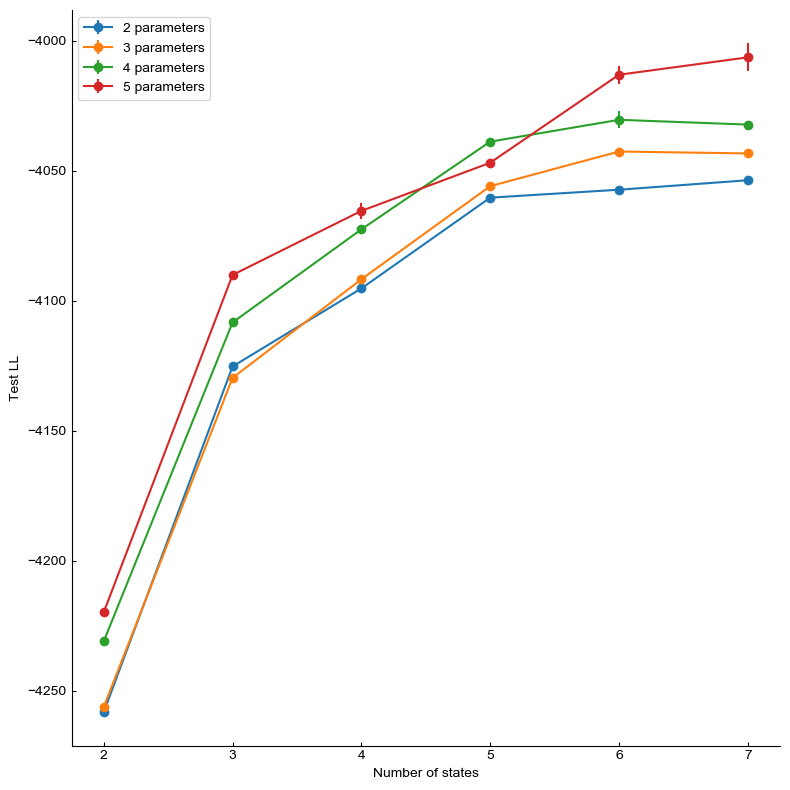

In [385]:
# Caclulate mean lof likelihoods and sem of log likelihoods across folds
mean_log_likelihoods = np.mean(log_likelihoods, axis=2)
sem_log_likelihoods = np.std(log_likelihoods, axis=2) / np.sqrt(num_folds)

# Plot mean log likelihoods and sem of log likelihoods as shaded error bars
ll_fig, ll_ax = plt.subplots(figsize=(8, 8))
for iModel in np.arange(len(num_params_array)):
    ll_ax.errorbar(num_states_cv, mean_log_likelihoods[iModel, :], yerr=sem_log_likelihoods[iModel, :], fmt='-o', label=str(num_params_array[iModel]) + ' parameters')
ll_ax.legend()
ll_ax.set_xticks(num_states_cv)
ll_ax.set_xlabel('Number of states')
ll_ax.set_ylabel('Test LL')

### Fit 5-parameter-5-state model to data to see what it looks like

In [386]:
# Initialize glm-hmm
num_states     = 5    # number of discrete states
obs_dim        = 1    # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim      = 5    # input dimensions

# Make a GLM-HMM
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Z-score inputs except for the first column
inputs_full_zscored = inputs_full.copy()
inputs_full_zscored[0, :, 1:] = zscore(inputs_full_zscored[0, :, 1:], axis=0)

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_full_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Plot predictor weights for each of the five states

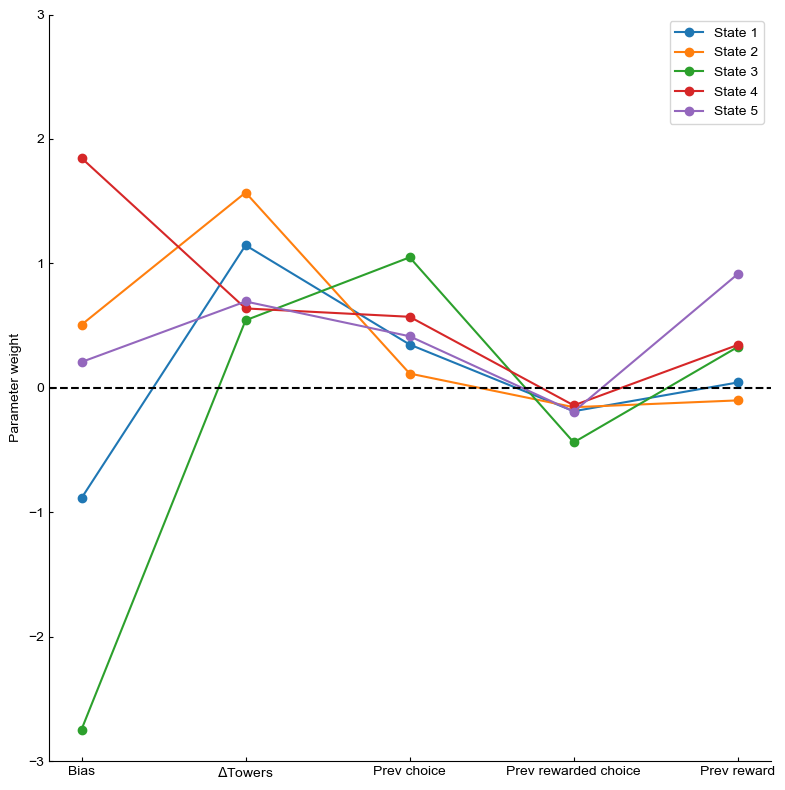

In [387]:
params = -np.squeeze(glmhmm.observations.params).T
fig_params, ax_params = plt.subplots(figsize=(8, 8))
ax_params.plot(params, '-o')
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev rewarded choice', 'Prev reward'])
ax_params.set_ylabel('Parameter weight')
ax_params.legend(['State 1', 'State 2', 'State 3', 'State 4', 'State 5'])

### Check state occupancy and performance by state

Text(0.5, 1.0, 'Overlap with high performance blocks')

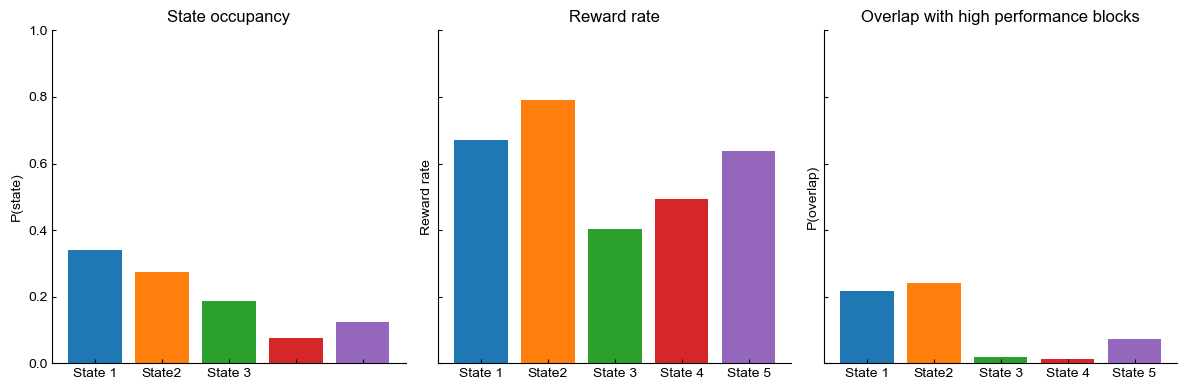

In [388]:
# Estimate posterior state probabilities
posterior_state_probs = glmhmm.expected_states(data=output, input=np.squeeze(inputs_full_zscored))

# Find the most likely state for each trial
most_likely_states = np.argmax(posterior_state_probs[0], axis=1)

# Intialize 1-by-3 subplots
fig_state_performance, ax_state_performance = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# State occupancy
state_occupancy = np.zeros(num_states)
for iState in np.arange(num_states):
    state_occupancy[iState] = np.mean(most_likely_states == iState)

# Plot state occupancy as bar plot
for iState in np.arange(num_states):
    ax_state_performance[0].bar(iState, state_occupancy[iState], color=colors[iState])
ax_state_performance[0].set_xticks(np.arange(num_states))
ax_state_performance[0].set_xticklabels(['State 1', 'State2', 'State 3'])
ax_state_performance[0].set_ylim([0, 1])
ax_state_performance[0].set_ylabel('P(state)')
ax_state_performance[0].set_title('State occupancy')

# Compare reward rates across states
rewarded = inputs_full[0, :, 4]
reward_rate_by_state = np.zeros(num_states)
for iState in np.arange(num_states):
    reward_rate_by_state[iState] = np.mean(rewarded[most_likely_states == iState])

# Plot reward rates across states as bar plot
for iState in np.arange(num_states):
    ax_state_performance[1].bar(iState, reward_rate_by_state[iState], color=colors[iState]) 
ax_state_performance[1].set_xticks(np.arange(num_states))
ax_state_performance[1].set_xticklabels(['State 1', 'State2', 'State 3', 'State 4', 'State 5'])
ax_state_performance[1].set_ylim([0, 1])
ax_state_performance[1].set_ylabel('Reward rate')
ax_state_performance[1].set_title('Reward rate')

# Compare overlaps between states and high-performance blocks across states
block_performance = data_mouse['block_performance'].values
above_perf_cutoff = block_performance >=0.6
for iState in np.arange(num_states):
    overlap = np.mean((most_likely_states == iState) & above_perf_cutoff)
    ax_state_performance[2].bar(iState, overlap, color=colors[iState])
ax_state_performance[2].set_xticks(np.arange(num_states))
ax_state_performance[2].set_xticklabels(['State 1', 'State2', 'State 3', 'State 4', 'State 5'])
ax_state_performance[2].set_ylim([0, 1])
ax_state_performance[2].set_ylabel('P(overlap)')
ax_state_performance[2].set_title('Overlap with high performance blocks')

### Fit 3-parameter-5-state model to data to see what it looks like

In [389]:
# Initialize glm-hmm
num_states     = 3    # number of discrete states
obs_dim        = 1    # number of observed dimensions
num_categories = 2    # number of categories for output
input_dim      = 5    # input dimensions

# Make a GLM-HMM
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Z-score inputs except for the first column
inputs_full_zscored = inputs_full.copy()
inputs_full_zscored[0, :, 1:] = zscore(inputs_full_zscored[0, :, 1:], axis=0)

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_full_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

### Plot predictor weights for each of the five states

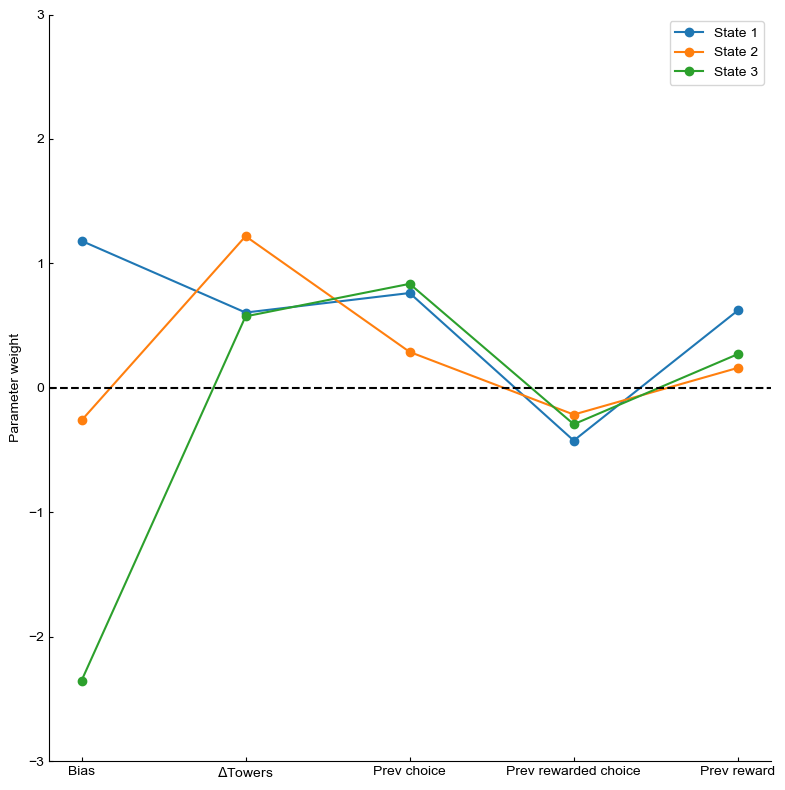

In [390]:
params = -np.squeeze(glmhmm.observations.params).T
colors = sns.color_palette()
fig_params, ax_params = plt.subplots(figsize=(8, 8))
for iState in np.arange(num_states):
    ax_params.plot(params[:, iState], '-o', color=colors[iState])
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev rewarded choice', 'Prev reward'])
ax_params.set_ylabel('Parameter weight')
ax_params.legend(['State 1', 'State 2', 'State 3'])

### Check state occupancy and performance by state

Text(0.5, 1.0, 'Overlap with high performance blocks')

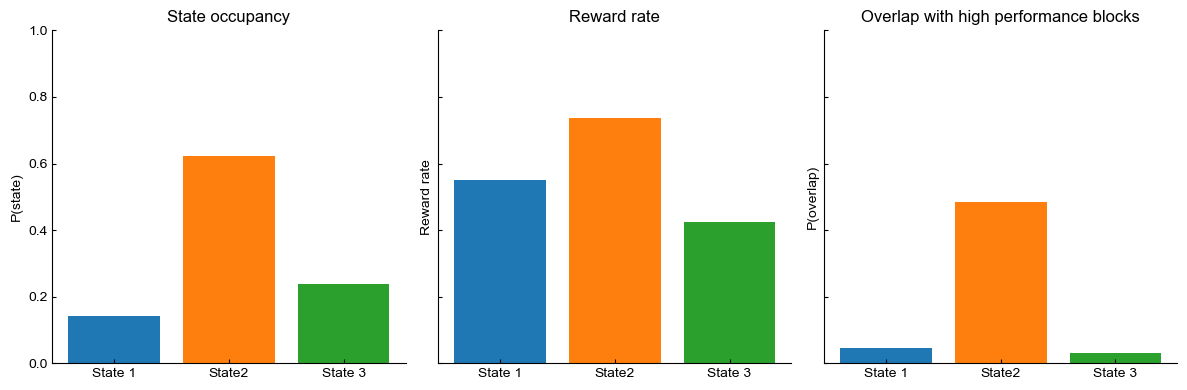

In [391]:
# Estimate posterior state probabilities
posterior_state_probs = glmhmm.expected_states(data=output, input=np.squeeze(inputs_full_zscored))

# Find the most likely state for each trial
most_likely_states = np.argmax(posterior_state_probs[0], axis=1)

# Intialize 1-by-3 subplots
fig_state_performance, ax_state_performance = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

# State occupancy
state_occupancy = np.zeros(num_states)
for iState in np.arange(num_states):
    state_occupancy[iState] = np.mean(most_likely_states == iState)

# Plot state occupancy as bar plot
for iState in np.arange(num_states):
    ax_state_performance[0].bar(iState, state_occupancy[iState], color=colors[iState])
ax_state_performance[0].set_xticks(np.arange(num_states))
ax_state_performance[0].set_xticklabels(['State 1', 'State2', 'State 3'])
ax_state_performance[0].set_ylim([0, 1])
ax_state_performance[0].set_ylabel('P(state)')
ax_state_performance[0].set_title('State occupancy')

# Compare reward rates across states
rewarded = inputs_full[0, :, 4]
reward_rate_by_state = np.zeros(num_states)
for iState in np.arange(num_states):
    reward_rate_by_state[iState] = np.mean(rewarded[most_likely_states == iState])

# Plot reward rates across states as bar plot
for iState in np.arange(num_states):
    ax_state_performance[1].bar(iState, reward_rate_by_state[iState], color=colors[iState]) 
ax_state_performance[1].set_xticks(np.arange(num_states))
ax_state_performance[1].set_xticklabels(['State 1', 'State2', 'State 3'])
ax_state_performance[1].set_ylim([0, 1])
ax_state_performance[1].set_ylabel('Reward rate')
ax_state_performance[1].set_title('Reward rate')

# Compare overlaps between states and high-performance blocks across states
block_performance = data_mouse['block_performance'].values
above_perf_cutoff = block_performance >=0.6
for iState in np.arange(num_states):
    overlap = np.mean((most_likely_states == iState) & above_perf_cutoff)
    ax_state_performance[2].bar(iState, overlap, color=colors[iState])
ax_state_performance[2].set_xticks(np.arange(num_states))
ax_state_performance[2].set_xticklabels(['State 1', 'State2', 'State 3'])
ax_state_performance[2].set_ylim([0, 1])
ax_state_performance[2].set_ylabel('P(overlap)')
ax_state_performance[2].set_title('Overlap with high performance blocks')

# Cross-validate across mice

## Definie function to fetch mouse data

In [474]:
def get_mouse_data(mouse_name, sessions_all_mice):

    # Variable restrictions
    out_vars = [
    'maze_id',
    'trial_type',
    'choice',
    'num_towers_left',
    'num_towers_right',
    'num_towers_delta',
    'trial_duration',
    'block_performance',
    'is_first_trial_of_block']

    # Fetch data for a single mouse
    sessions_mouse = sessions_all_mice.loc[sessions_all_mice['subject_fullname'] == mouse_name, :]
    data_mouse = pd.DataFrame((VM['behavior'].TowersSessionTrial & sessions_mouse).proj(*out_vars).fetch())

    # Make chose right response vector
    chose_right = np.zeros(len(data_mouse['choice']))
    chose_right[data_mouse['choice'] == 'R'] = 1
    chose_right = chose_right.astype(int)
    data_mouse['chose_right'] = chose_right

    # Make choice history matrix
    signed_choices = np.zeros(len(data_mouse['choice']))
    signed_choices[data_mouse['choice'] == 'R'] = 1
    signed_choices[data_mouse['choice'] == 'L'] = -1
    num_prev_trial = 5
    choice_history = qb.make_history_matrix(signed_choices, data_mouse['trial_id'], num_prev_trial)
    choice_history = choice_history.astype(int)
    data_mouse['prev_choice_1'] = choice_history[:, 0]

    # Make reward history matrix
    reward = np.zeros(len(data_mouse['choice'])).astype(int)
    reward[data_mouse['choice'] == data_mouse['trial_type']] = 1
    data_mouse['rewarded'] = reward
    num_prev_trial = 5
    reward_history = qb.make_history_matrix(reward, data_mouse['trial_id'], num_prev_trial)
    reward_history = reward_history.astype(int)
    data_mouse['prev_reward_1'] = reward_history[:, 0]

    # Make rewarded choice history matrix
    rewarded_choice_history = choice_history * reward_history
    data_mouse['prev_rewarded_choice_1'] = rewarded_choice_history[:, 0]

    # Select only maze 11 trials and emove nil choice trials
    data_mouse = data_mouse.loc[data_mouse['maze_id'] == 11, :]
    data_mouse = data_mouse.loc[data_mouse['choice'] != 'nil', :]
    data_mouse = data_mouse.reset_index(drop=True)

    return data_mouse

## Define function to cross-validate for a given mouse

In [475]:
def cv_glmhmm_mouse(data_mouse, num_params_array=[2, 3, 4, 5], num_states_cv=[2, 3, 4, 5, 6, 7], num_folds=3, max_iter=1000):

    # Considering all sessions as one combined session
    num_sessions = 1

    # Initialize log likelihoods and std of likelihoods for each fold
    log_likelihoods = np.zeros((len(num_params_array), len(num_states_cv), num_folds))

    # Organize design matrix for all potential predictors and full dataset
    inputs_full = np.ones((num_sessions, len(data_mouse), np.max(num_params_array)))
    if np.max(num_params_array) >= 2:
        inputs_full[0, :, 1] = data_mouse['num_towers_delta']
        if np.max(num_params_array) >= 3:
            inputs_full[0, :, 2] = data_mouse['prev_choice_1']
            if np.max(num_params_array) >= 4:
                inputs_full[0, :, 3] = data_mouse['prev_rewarded_choice_1']
                if np.max(num_params_array) >= 5:
                    inputs_full[0, :, 4] = data_mouse['prev_reward_1']

    # Organize response vector for full dataset
    output = np.zeros((len(data_mouse), 1)).astype(int)
    output[:, 0] = data_mouse['chose_right'].values

    for iFold in np.arange(num_folds):

        # Split data into training and test sets
        train_sessions, test_sessions = ms.train_test_split(sessions_mouse, test_size=1/num_folds, random_state=0)

        # Index data for training and test sets based on session date
        idx_train = data_mouse['session_date'].isin(train_sessions['session_date'])
        idx_test = data_mouse['session_date'].isin(test_sessions['session_date'])

        # Assemble inputs for all potential predictors for training and test sets
        inputs_all_train = inputs_full[:, idx_train, :]
        inputs_all_test = inputs_full[:, idx_test, :]

        # Z-score inputs for training and test sets except for the first column
        inputs_all_train[0, :, 1:] = zscore(inputs_all_train[0, :, 1:], axis=0)
        inputs_all_test[0, :, 1:] = zscore(inputs_all_test[0, :, 1:], axis=0)

        # Assemble response vector for training and test sets
        output_train = output[idx_train]
        output_test = output[idx_test]

        # Package outputs as list
        output_train = [output_train]
        output_test = [output_test]

        # Print progress for fold
        print('Fold ' + str(iFold + 1) + ' of ' + str(num_folds))

        # Loop over candidate models
        for iModel, num_params in enumerate(num_params_array):

            # Loop over numbers of pre-specified states
            for iState, num_states in enumerate(num_states_cv):

                # Select number of parameters for inputs
                inputs_train = inputs_all_train[:, :, :num_params]
                inputs_test = inputs_all_test[:, :, :num_params]

                # Package inputs as list
                inputs_train = list(inputs_train)
                inputs_test = list(inputs_test)

                # Initialize model
                obs_dim = 1 # number of observed dimensions
                num_categories = 2 # number of categories for output            
                glmhmm = ssm.HMM(num_states, obs_dim, num_params, observations="input_driven_obs",
                                observation_kwargs=dict(C=num_categories), transitions="standard")
                
                # Fit model to training data
                glmhmm.fit(output_train, inputs=inputs_train, method="em", num_iters=max_iter, tolerance=10e-4)

                # Compute log likelihood of test data
                log_likelihoods[iModel, iState, iFold] = glmhmm.log_likelihood(output_test, inputs=inputs_test)

                # Print progress for param-state pair
                print('Done fitting model with ' + str(num_params) + ' parameters and ' + str(num_states) + ' states')

    # Caclulate mean lof likelihoods and sem of log likelihoods across folds
    mean_log_likelihoods = np.mean(log_likelihoods, axis=2)
    sem_log_likelihoods = np.std(log_likelihoods, axis=2) / np.sqrt(num_folds)

    return mean_log_likelihoods, sem_log_likelihoods

## Define function to plot state statistics

In [527]:
def plot_state_stats(glmhmm, data_mouse, inputs, output):

    # Estimate posterior state probabilities
    posterior_state_probs = glmhmm.expected_states(data=output, input=np.squeeze(inputs))

    # Find the most likely state for each trial
    most_likely_states = np.argmax(posterior_state_probs[0], axis=1)

    # Intialize 1-by-3 subplots
    _, ax_state_performance = plt.subplots(1, 3, figsize=(13, 4), sharey=True)

    # Number each state
    num_states = glmhmm.K
    state_labels = ['State ' + str(iState + 1) for iState in np.arange(num_states)]
    
    # State occupancy
    state_occupancy = np.zeros(num_states)
    for iState in np.arange(num_states):
        state_occupancy[iState] = np.mean(most_likely_states == iState)

    # Plot state occupancy as bar plot
    for iState in np.arange(num_states):
        ax_state_performance[0].bar(iState, state_occupancy[iState], color=colors[iState])
        ax_state_performance[0].set_xticks(np.arange(num_states))
        ax_state_performance[0].set_xticklabels(state_labels, fontsize=14)
        ax_state_performance[0].set_ylim([0, 1])
        ax_state_performance[0].set_ylabel('P(state)', fontsize=18)
        ax_state_performance[0].set_title('State occupancy', fontsize=18)

    # Compare reward rates across states
    rewarded = data_mouse['rewarded'].values
    reward_rate_by_state = np.zeros(num_states)
    for iState in np.arange(num_states):
        reward_rate_by_state[iState] = np.mean(rewarded[most_likely_states == iState])

    # Plot reward rates across states as bar plot
    for iState in np.arange(num_states):
        ax_state_performance[1].bar(iState, reward_rate_by_state[iState], color=colors[iState]) 
        ax_state_performance[1].set_xticks(np.arange(num_states))
        ax_state_performance[1].set_xticklabels(state_labels, fontsize=14)
        ax_state_performance[1].set_ylim([0, 1])
        ax_state_performance[1].set_ylabel('Reward rate', fontsize=18)
        ax_state_performance[1].set_title('Reward rate', fontsize=18)

    # Compare overlaps between states and high-performance blocks across states
    block_performance = data_mouse['block_performance'].values
    above_perf_cutoff = block_performance >=0.6
    for iState in np.arange(num_states):
        overlap = np.mean((most_likely_states == iState) & above_perf_cutoff)
        ax_state_performance[2].bar(iState, overlap, color=colors[iState])
        ax_state_performance[2].set_xticks(np.arange(num_states))
        ax_state_performance[2].set_xticklabels(state_labels, fontsize=14)
        ax_state_performance[2].set_ylim([0, 1])
        ax_state_performance[2].set_ylabel('P(overlap)', fontsize=18)
        ax_state_performance[2].set_title('Overlap with high performance blocks', fontsize=18)

## Cross-validate across mice

In [401]:
# Initialize x mice storage
mean_log_likelihoods_x_mice = []
sem_log_likelihoods_x_mice = []

# Cross-validation parameters
num_folds = 3 
num_params_array = [2, 3, 4, 5] 
num_states_cv = [2, 3, 4, 5, 6, 7] 
max_iter = 1000

# Loop over mice
for iMouse, mouse_name in enumerate(mice_selected):

    # Fetch data for a single mouse
    data_mouse = get_mouse_data(mouse_name, sessions_all_mice)

    # Cross-validate GLM-HMM
    mean_log_likelihoods, sem_log_likelihoods = cv_glmhmm_mouse(data_mouse, num_params_array=num_params_array, num_states_cv=num_states_cv, num_folds=num_folds, max_iter=max_iter)

    # Store results
    mean_log_likelihoods_x_mice.append(mean_log_likelihoods)
    sem_log_likelihoods_x_mice.append(sem_log_likelihoods)

[2024-02-07 16:41:38,322][WARNING]: MySQL server has gone away. Reconnecting to the server.


Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-07 18:14:05,733][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-07 21:41:10,697][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-07 23:45:45,226][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-08 04:39:45,320][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
D

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-08 10:49:20,545][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-08 12:07:38,164][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-08 15:15:23,458][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states


## Plot cross-validation likelihoods across mice

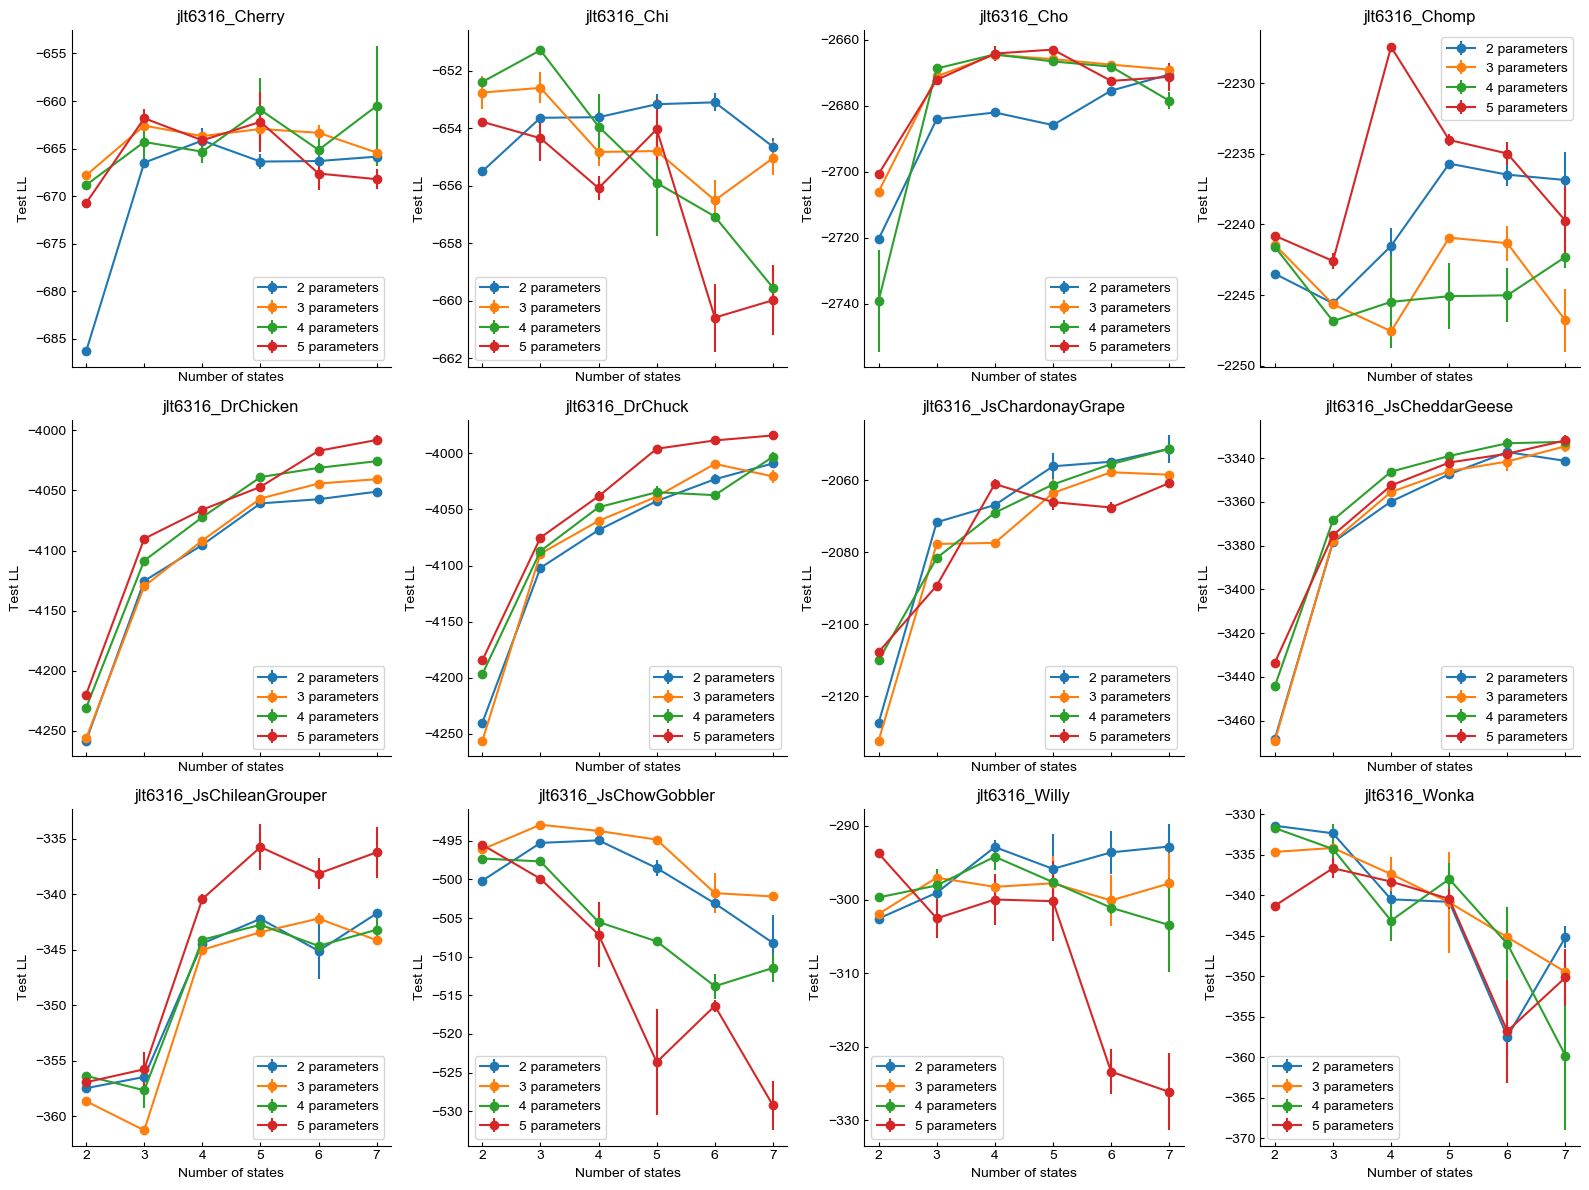

In [410]:
# Make 3 x 4 subplots, one for each mouse
fig_mice_cv, ax_mice_cv = plt.subplots(3, 4, figsize=(16, 12), sharex=True)

for iMouse, mouse_name in enumerate(mice_selected):

    # Loop over candidate models
    for iModel, num_params in enumerate(num_params_array):

        # Plot likelihoods and sem for each mouse
        ax_mice_cv.flatten()[iMouse].errorbar(num_states_cv, mean_log_likelihoods_x_mice[iMouse][iModel, :], yerr=sem_log_likelihoods_x_mice[iMouse][iModel, :], fmt='-o', label=str(num_params) + ' parameters')
        ax_mice_cv.flatten()[iMouse].set_xticks(num_states_cv)
        ax_mice_cv.flatten()[iMouse].set_xlabel('Number of states')
        ax_mice_cv.flatten()[iMouse].set_ylabel('Test LL')
        ax_mice_cv.flatten()[iMouse].set_title(mouse_name)
        ax_mice_cv.flatten()[iMouse].legend()


# Do the same cross-validation across mice but with a moderate session-wide performance threshold

## Select sessions

In [413]:
# Fetch sessions
mice_keith = qb.getMouseByUser('keith')
performance = pd.DataFrame((VM['behavior'].Performance & qb.genFilter('subject_fullname', mice_keith) & qb.genFilter('task', 'TowersTaskSwitch')).fetch())

# Remove sessions that were aborted
performance = qb.rm_abort_session(performance)

# Include only sessions that have mazes
has_mazes = [these_mazes is not None for these_mazes in performance['all_maze_id']]
performance = performance.loc[has_mazes, :]

# Include only sessions that have maze 4, 11, 12
has_correct_mazes = [these_mazes.tolist() == [[4], [11], [12]] for these_mazes in performance['all_maze_id']]
performance = performance.loc[has_correct_mazes, :]

# Include only sessions that have decent session-wide performance
has_good_performance = [this_perf[1][0] > 0.5 for this_perf in performance['proportion_correct']]
performance = performance.loc[has_good_performance, :]
performance = performance.reset_index(drop=True)

# Include only mice that have at least 20 sessions
session_count_by_mouse = performance.groupby('subject_fullname').size()
mice_selected = session_count_by_mouse[session_count_by_mouse > 10].index.tolist()
performance = performance.loc[performance['subject_fullname'].isin(mice_selected), :]

# Fetch only the primary keys for the sessions
sessions_all_mice = pd.DataFrame((VM['session'].Session & performance).fetch('KEY'))

[2024-02-09 13:20:29,211][WARNING]: MySQL server has gone away. Reconnecting to the server.


In [416]:
sessions_all_mice.groupby('subject_fullname').size()

subject_fullname
jlt6316_Cherry               13
jlt6316_Chi                  65
jlt6316_Cho                  76
jlt6316_Chomp                89
jlt6316_Chrabcake            12
jlt6316_DrChicken            91
jlt6316_DrChuck             104
jlt6316_JsChardonayGrape     68
jlt6316_JsCheddarGeese      117
jlt6316_JsChileanGrouper     19
jlt6316_Wonka                14
dtype: int64

## Cross-validate across mice

In [421]:
# Initialize x mice storage
mean_log_likelihoods_x_mice = []
sem_log_likelihoods_x_mice = []

# Cross-validation parameters
num_folds = 3 
num_params_array = [2, 3, 4, 5] 
num_states_cv = [2, 3, 4, 5, 6, 7] 
max_iter = 1000

# Loop over mice
for iMouse, mouse_name in enumerate(mice_selected):

    # Fetch data for a single mouse
    data_mouse = get_mouse_data(mouse_name, sessions_all_mice)

    # Cross-validate GLM-HMM
    mean_log_likelihoods, sem_log_likelihoods = cv_glmhmm_mouse(data_mouse, num_params_array=num_params_array, num_states_cv=num_states_cv, num_folds=num_folds, max_iter=max_iter)

    # Store results
    mean_log_likelihoods_x_mice.append(mean_log_likelihoods)
    sem_log_likelihoods_x_mice.append(sem_log_likelihoods)

Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-09 16:09:19,135][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-09 18:38:14,989][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-09 21:13:44,182][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
D

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
D

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-10 01:08:35,861][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-10 06:13:47,835][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-10 07:47:17,322][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

[2024-02-10 11:38:08,311][WARNING]: MySQL server has gone away. Reconnecting to the server.


Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 1 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 2 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states
Fold 3 of 3


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 2 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 3 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 4 parameters and 7 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 2 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 3 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 4 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 5 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 6 states


  0%|          | 0/1000 [00:00<?, ?it/s]

Done fitting model with 5 parameters and 7 states


## Plot Cross-validation results across mice

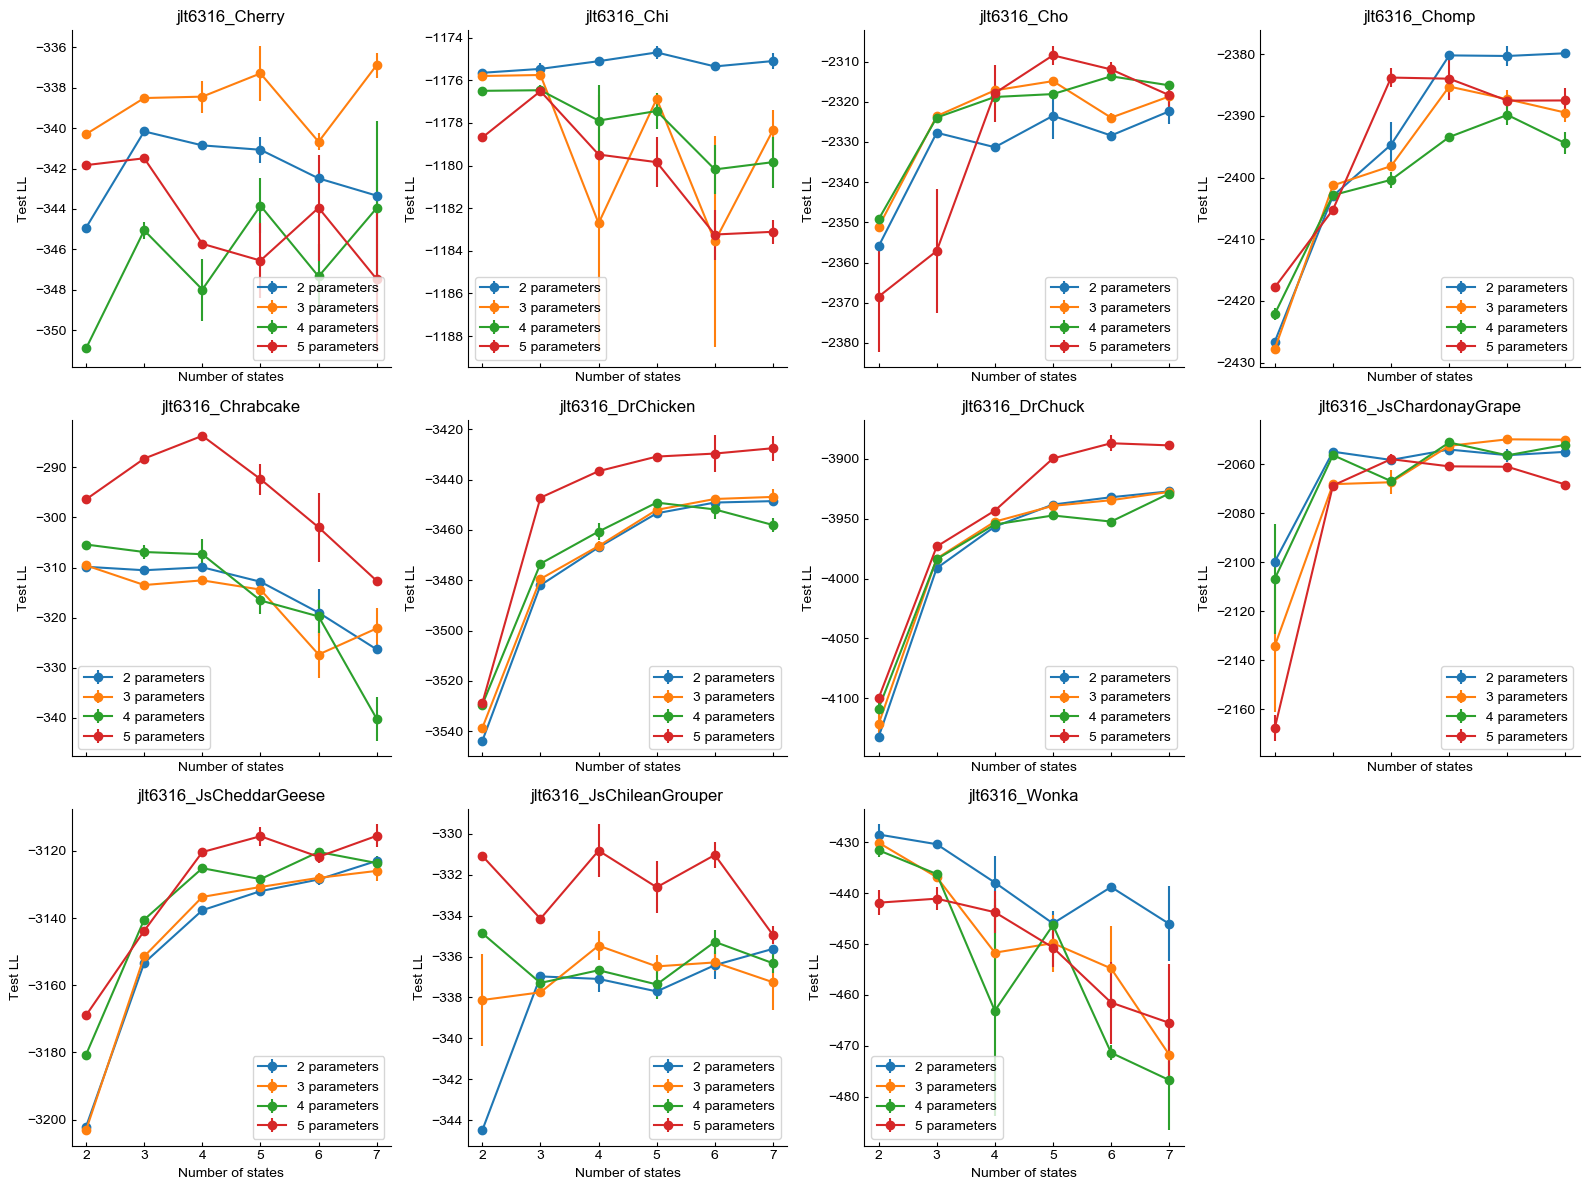

In [450]:
fig_mice_cv, ax_mice_cv = plt.subplots(3, 4, figsize=(16, 12), sharex=True)

for iMouse, mouse_name in enumerate(mice_selected):

    # Loop over candidate models
    for iModel, num_params in enumerate(num_params_array):

        # Plot likelihoods and sem for each mouse
        ax_mice_cv.flatten()[iMouse].errorbar(num_states_cv, mean_log_likelihoods_x_mice[iMouse][iModel, :], yerr=sem_log_likelihoods_x_mice[iMouse][iModel, :], fmt='-o', label=str(num_params) + ' parameters')
        ax_mice_cv.flatten()[iMouse].set_xticks(num_states_cv)
        ax_mice_cv.flatten()[iMouse].set_xlabel('Number of states')
        ax_mice_cv.flatten()[iMouse].set_ylabel('Test LL')
        ax_mice_cv.flatten()[iMouse].set_title(mouse_name)
        ax_mice_cv.flatten()[iMouse].legend()

# Remove empty subplots
ax_mice_cv.flatten()[-1].remove()

# Examine individual mice that dont fit the 3-state 5-predictor template

## Cho, 5-predictor works poorly for 3-state but works well for 4-state

In [529]:
# Get mouse data
mouse_name = mice_selected[2]
data_mouse = get_mouse_data(mouse_name, sessions_all_mice)

# Full input matrix
num_params_total = 5
inputs_full = np.ones((num_sessions, len(data_mouse), num_params_total))
inputs_full[0, :, 1] = data_mouse['num_towers_delta']
inputs_full[0, :, 2] = data_mouse['prev_choice_1']
inputs_full[0, :, 3] = data_mouse['prev_rewarded_choice_1']
inputs_full[0, :, 4] = data_mouse['prev_reward_1']

[2024-02-15 22:29:36,227][WARNING]: MySQL server has gone away. Reconnecting to the server.


### 3-state 3-predictor

In [530]:
# Organize response vector for full dataset
output = np.zeros((len(data_mouse), 1)).astype(int)
output[:, 0] = data_mouse['chose_right'].values

# Organize design matrix for all potential predictors and full dataset
num_params = 3
inputs = inputs_full[: , :, :num_params]

# Z-score inputs except for the first column
inputs_zscored = inputs.copy()  
inputs_zscored[0, :, 1:] = zscore(inputs_zscored[0, :, 1:], axis=0)

# Initialize glm-hmm
num_states = 3         # number of discrete states
obs_dim = 1            # number of observed dimensions
num_categories = 2     # number of categories for output
input_dim = num_params # input dimensions

# Initialize glm-hmm
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plot predictor weights

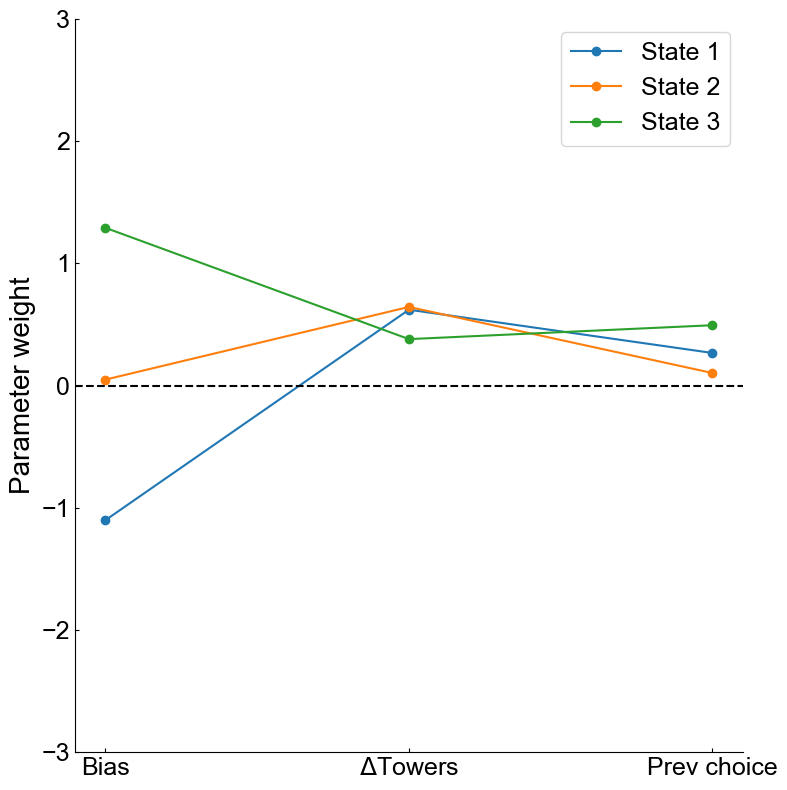

In [531]:
params = -np.squeeze(glmhmm.observations.params).T
colors = sns.color_palette()
fig_params, ax_params = plt.subplots(figsize=(8, 8))
for iState in np.arange(num_states):
    ax_params.plot(params[:, iState], '-o', color=colors[iState])
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev \n rewarded choice', 'Prev \n reward'])
ax_params.set_ylabel('Parameter weight', fontsize=20)
ax_params.legend(['State 1', 'State 2', 'State 3'], fontsize=18)

# Set tick label font size to 18
ax_params.tick_params(axis='both', which='major', labelsize=18)

#### State statistics

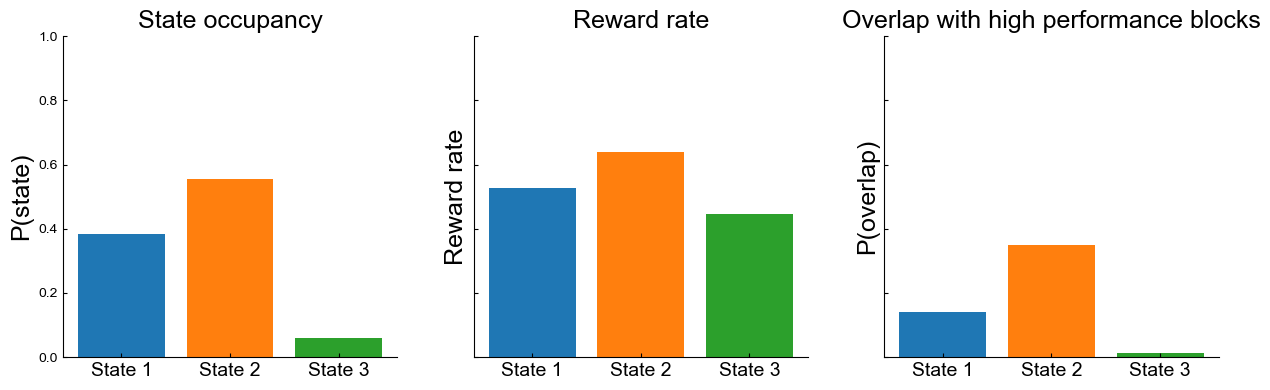

In [532]:
plot_state_stats(glmhmm, data_mouse, inputs_zscored, output)

### 3-state 5-predictor

In [538]:
# Organize response vector for full dataset
output = np.zeros((len(data_mouse), 1)).astype(int)
output[:, 0] = data_mouse['chose_right'].values

# Organize design matrix for all potential predictors and full dataset
num_params = 5
inputs = inputs_full[: , :, :num_params]

# Z-score inputs except for the first column
inputs_zscored = inputs.copy()  
inputs_zscored[0, :, 1:] = zscore(inputs_zscored[0, :, 1:], axis=0)

# Initialize glm-hmm
num_states = 3         # number of discrete states
obs_dim = 1            # number of observed dimensions
num_categories = 2     # number of categories for output
input_dim = num_params # input dimensions

# Initialize glm-hmm
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plot predictor weights

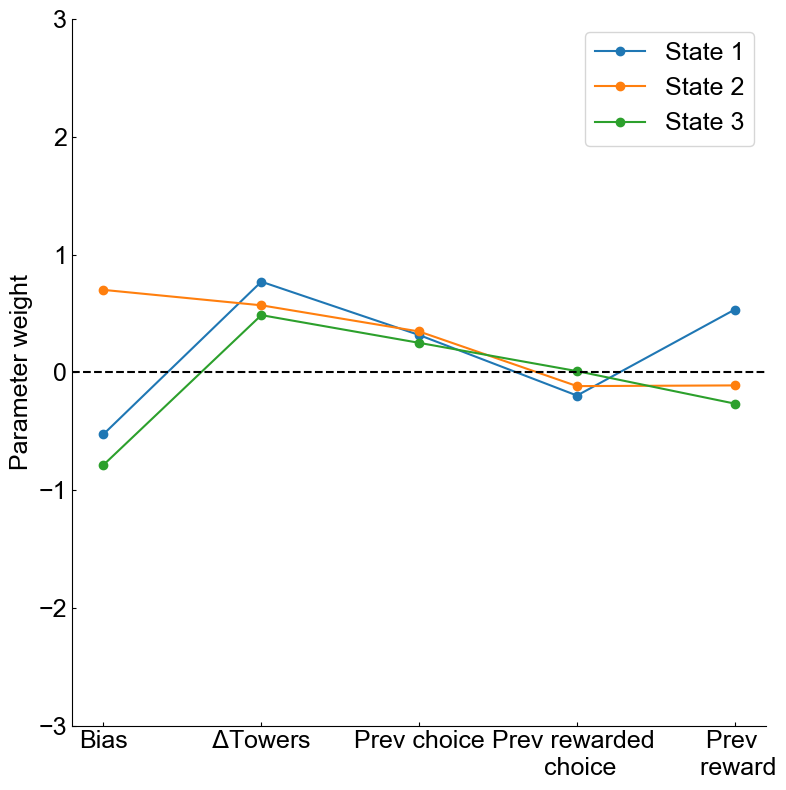

In [540]:
params = -np.squeeze(glmhmm.observations.params).T
colors = sns.color_palette()
fig_params, ax_params = plt.subplots(figsize=(8, 8))
for iState in np.arange(num_states):
    ax_params.plot(params[:, iState], '-o', color=colors[iState])
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev rewarded \n choice', 'Prev \n reward'])
ax_params.set_ylabel('Parameter weight', fontsize=18)
ax_params.legend(['State 1', 'State 2', 'State 3'], fontsize=18)
ax_params.tick_params(axis='both', which='major', labelsize=18)

#### State statistics

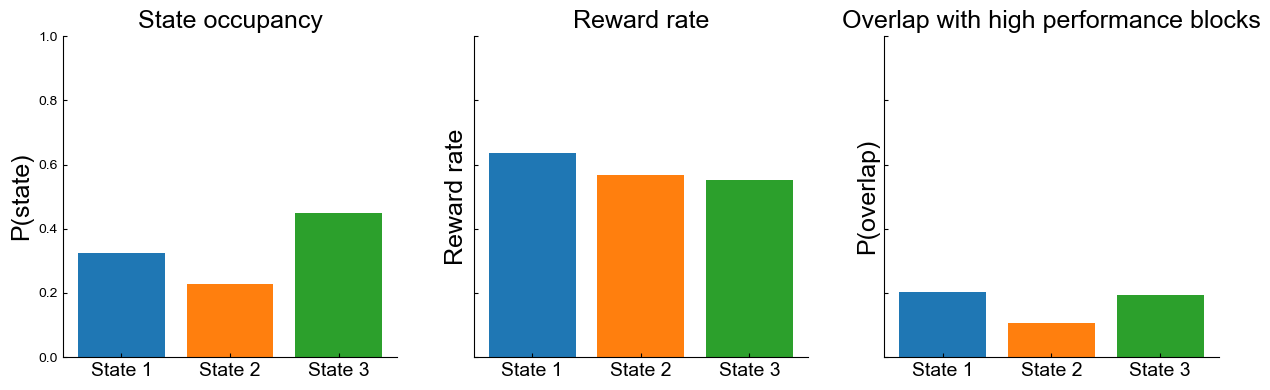

In [541]:
plot_state_stats(glmhmm, data_mouse, inputs_zscored, output)

### 4-state 5-predictor

In [542]:
# Organize response vector for full dataset
output = np.zeros((len(data_mouse), 1)).astype(int)
output[:, 0] = data_mouse['chose_right'].values

# Organize design matrix for all potential predictors and full dataset
num_params = 5
inputs= inputs_full[: , :, :num_params]

# Z-score inputs except for the first column
inputs_zscored = inputs.copy()  
inputs_zscored[0, :, 1:] = zscore(inputs_zscored[0, :, 1:], axis=0)

# Initialize glm-hmm
num_states = 4         # number of discrete states
obs_dim = 1            # number of observed dimensions
num_categories = 2     # number of categories for output
input_dim = num_params # input dimensions

# Initialize glm-hmm
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))
c:\users\jlt6316\experiments\ssm\ssm\optimizers.py:146: UserWarning: BFGS failed with message:
Desired error not necessarily achieved due to precision loss.
  warn("{} failed with message:\n{}".format(method, result.message))


#### Plot predictor weights

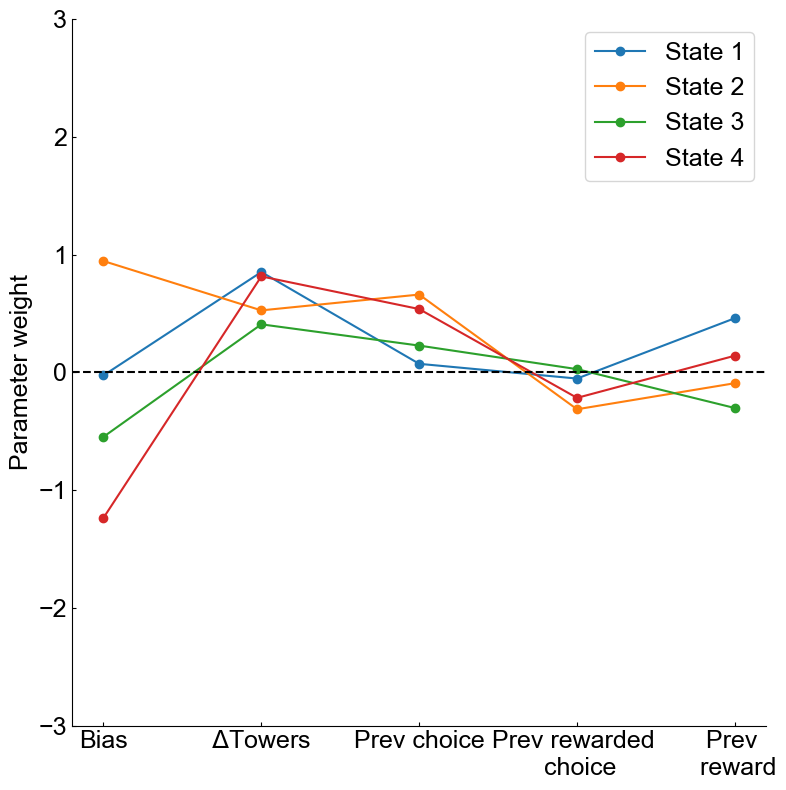

In [543]:
params = -np.squeeze(glmhmm.observations.params).T
colors = sns.color_palette()
fig_params, ax_params = plt.subplots(figsize=(8, 8))
for iState in np.arange(num_states):
    ax_params.plot(params[:, iState], '-o', color=colors[iState])
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev rewarded \n choice', 'Prev \n reward'])
ax_params.set_ylabel('Parameter weight', fontsize=18)
ax_params.legend(['State 1', 'State 2', 'State 3', 'State 4'], fontsize=18)
ax_params.tick_params(axis='both', which='major', labelsize=18)

#### State statistics

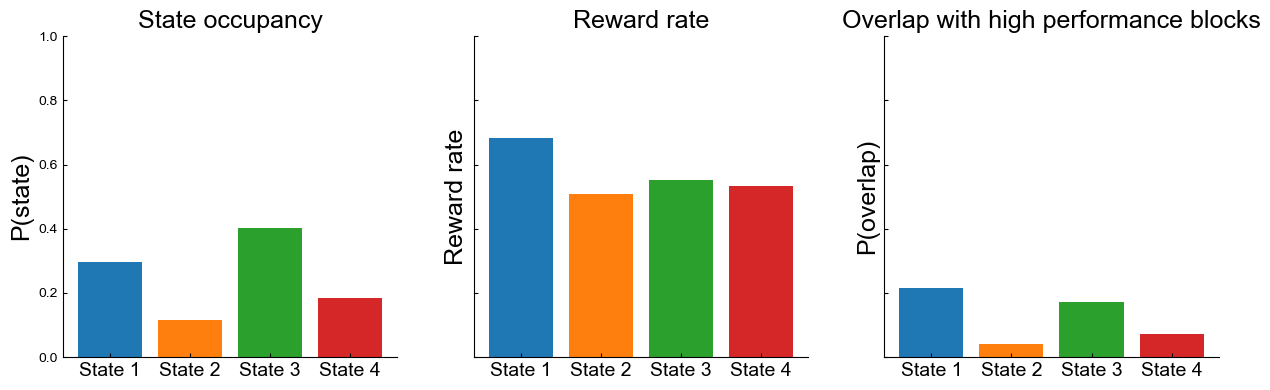

In [544]:
plot_state_stats(glmhmm, data_mouse, inputs_zscored, output)

## Chomp, 4-state seems to be the elbow point

In [545]:
# Get mouse data
mouse_name = mice_selected[3]
data_mouse = get_mouse_data(mouse_name, sessions_all_mice)

### 3-state 5-predictor

In [546]:
# Organize response vector for full dataset
output = np.zeros((len(data_mouse), 1)).astype(int)
output[:, 0] = data_mouse['chose_right'].values

# Organize design matrix for all potential predictors and full dataset
num_params = 5
inputs= np.ones((num_sessions, len(data_mouse), num_params))
inputs[0, :, 1] = data_mouse['num_towers_delta']
inputs[0, :, 2] = data_mouse['prev_choice_1']
inputs[0, :, 3] = data_mouse['prev_rewarded_choice_1']
inputs[0, :, 4] = data_mouse['prev_reward_1']

# Z-score inputs except for the first column
inputs_zscored = inputs.copy()  
inputs_zscored[0, :, 1:] = zscore(inputs_zscored[0, :, 1:], axis=0)

# Initialize glm-hmm
num_states = 3     # number of discrete states
obs_dim = 1        # number of observed dimensions
num_categories = 2 # number of categories for output
input_dim = 5      # input dimensions

# Initialize glm-hmm
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plot predictor weights

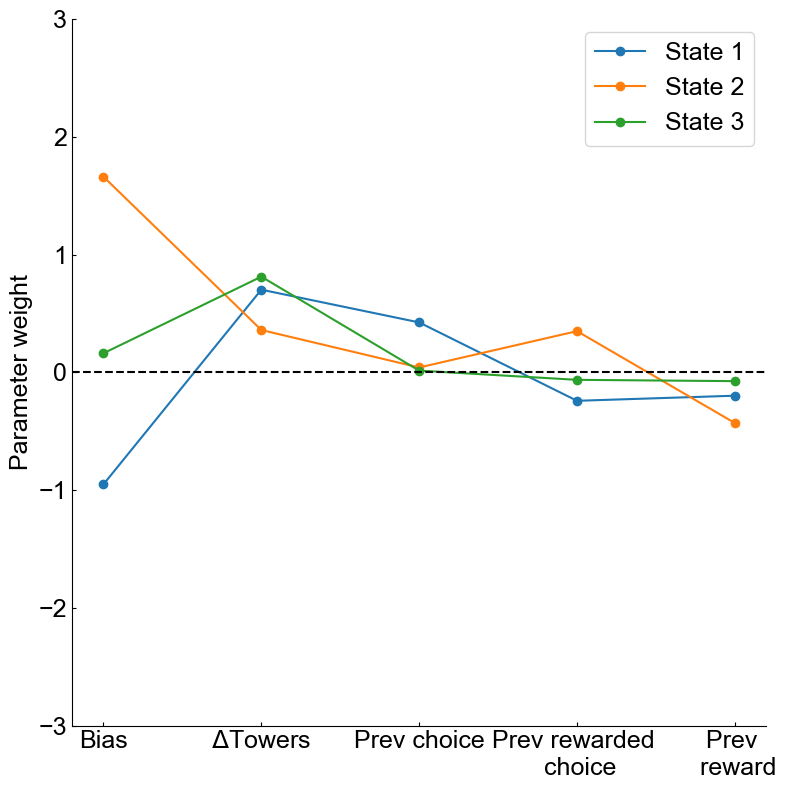

In [548]:
params = -np.squeeze(glmhmm.observations.params).T
colors = sns.color_palette()
fig_params, ax_params = plt.subplots(figsize=(8, 8))
for iState in np.arange(num_states):
    ax_params.plot(params[:, iState], '-o', color=colors[iState])
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev rewarded \n choice', 'Prev \n reward'])
ax_params.set_ylabel('Parameter weight', fontsize=18)
ax_params.legend(['State 1', 'State 2', 'State 3'], fontsize=18)
ax_params.tick_params(axis='both', which='major', labelsize=18)

#### State statistics

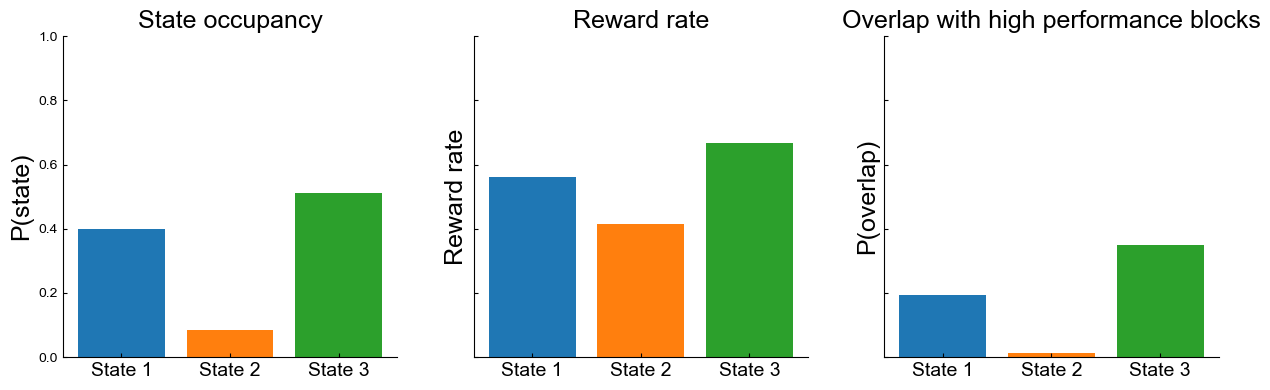

In [549]:
plot_state_stats(glmhmm, data_mouse, inputs_zscored, output)

### 4-state 5-predictor

In [550]:
# Organize response vector for full dataset
output = np.zeros((len(data_mouse), 1)).astype(int)
output[:, 0] = data_mouse['chose_right'].values

# Organize design matrix for all potential predictors and full dataset
num_params = 5
inputs= np.ones((num_sessions, len(data_mouse), num_params))
inputs[0, :, 1] = data_mouse['num_towers_delta']
inputs[0, :, 2] = data_mouse['prev_choice_1']
inputs[0, :, 3] = data_mouse['prev_rewarded_choice_1']
inputs[0, :, 4] = data_mouse['prev_reward_1']

# Z-score inputs except for the first column
inputs_zscored = inputs.copy()  
inputs_zscored[0, :, 1:] = zscore(inputs_zscored[0, :, 1:], axis=0)

# Initialize glm-hmm
num_states = 4     # number of discrete states
obs_dim = 1        # number of observed dimensions
num_categories = 2 # number of categories for output
input_dim = 5      # input dimensions

# Initialize glm-hmm
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plot predictor weight

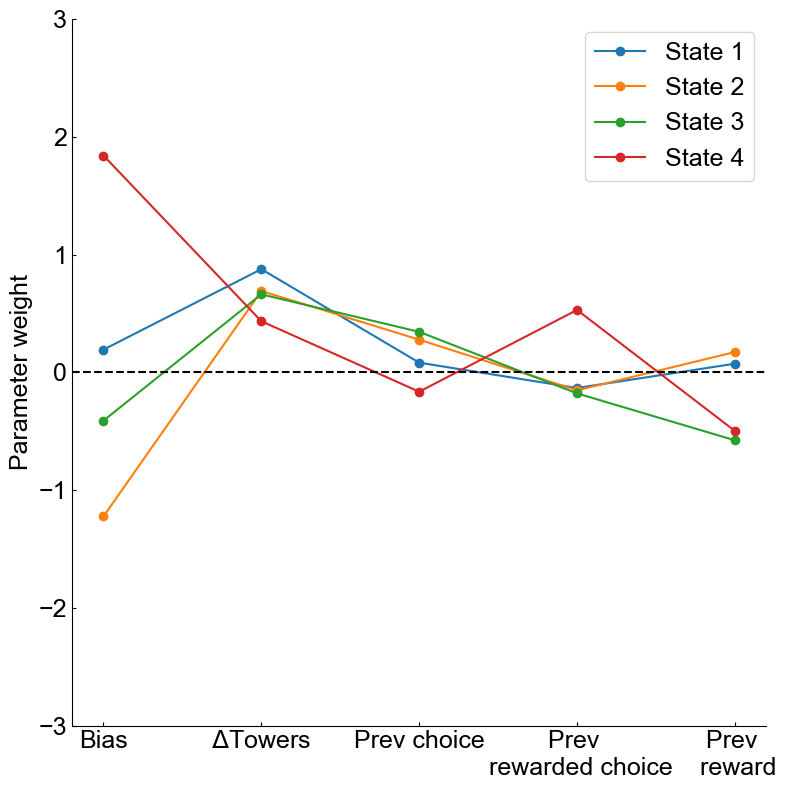

In [551]:
params = -np.squeeze(glmhmm.observations.params).T
colors = sns.color_palette()
fig_params, ax_params = plt.subplots(figsize=(8, 8))
for iState in np.arange(num_states):
    ax_params.plot(params[:, iState], '-o', color=colors[iState])
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev \n rewarded choice', 'Prev \n reward'])
ax_params.set_ylabel('Parameter weight', fontsize=18)
ax_params.legend(['State 1', 'State 2', 'State 3', 'State 4'], fontsize=18)
ax_params.tick_params(axis='both', which='major', labelsize=18)

#### State statistics

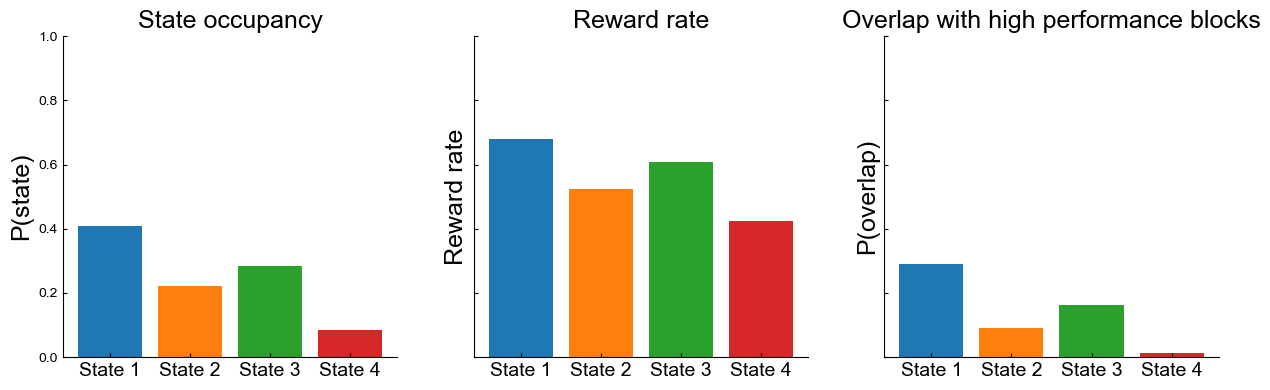

In [552]:
plot_state_stats(glmhmm, data_mouse, inputs_zscored, output)

## JsCheddarGeese, 4-state seems to be the elbow

In [553]:
# Get mouse data
mouse_name = mice_selected[8]
data_mouse = get_mouse_data(mouse_name, sessions_all_mice)

### 3-state 5-predictor

In [554]:
# Organize response vector for full dataset
output = np.zeros((len(data_mouse), 1)).astype(int)
output[:, 0] = data_mouse['chose_right'].values

# Organize design matrix for all potential predictors and full dataset
num_params = 5
inputs= np.ones((num_sessions, len(data_mouse), num_params))
inputs[0, :, 1] = data_mouse['num_towers_delta']
inputs[0, :, 2] = data_mouse['prev_choice_1']
inputs[0, :, 3] = data_mouse['prev_rewarded_choice_1']
inputs[0, :, 4] = data_mouse['prev_reward_1']

# Z-score inputs except for the first column
inputs_zscored = inputs.copy()  
inputs_zscored[0, :, 1:] = zscore(inputs_zscored[0, :, 1:], axis=0)

# Initialize glm-hmm
num_states = 3     # number of discrete states
obs_dim = 1        # number of observed dimensions
num_categories = 2 # number of categories for output
input_dim = 5      # input dimensions

# Initialize glm-hmm
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plot predictor weights

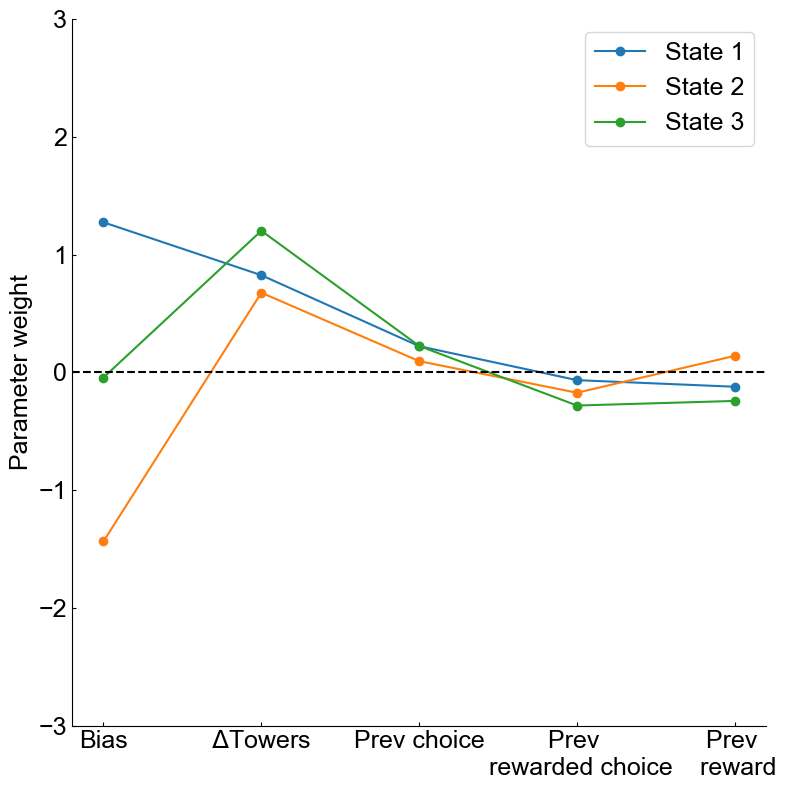

In [557]:
params = -np.squeeze(glmhmm.observations.params).T
colors = sns.color_palette()
fig_params, ax_params = plt.subplots(figsize=(8, 8))
for iState in np.arange(num_states):
    ax_params.plot(params[:, iState], '-o', color=colors[iState])
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev \n rewarded choice', 'Prev \n reward'])
ax_params.set_ylabel('Parameter weight', fontsize=18)
ax_params.legend(['State 1', 'State 2', 'State 3'], fontsize=18)
ax_params.tick_params(axis='both', which='major', labelsize=18)

#### State statistics

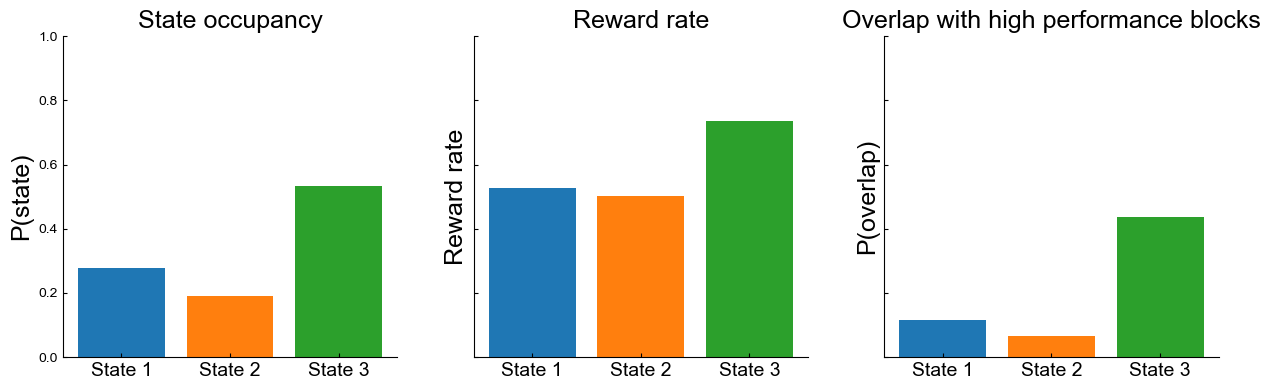

In [558]:
plot_state_stats(glmhmm, data_mouse, inputs_zscored, output)

### 4-state 5-predictor

In [559]:
# Organize response vector for full dataset
output = np.zeros((len(data_mouse), 1)).astype(int)
output[:, 0] = data_mouse['chose_right'].values

# Organize design matrix for all potential predictors and full dataset
num_params = 5
inputs= np.ones((num_sessions, len(data_mouse), num_params))
inputs[0, :, 1] = data_mouse['num_towers_delta']
inputs[0, :, 2] = data_mouse['prev_choice_1']
inputs[0, :, 3] = data_mouse['prev_rewarded_choice_1']
inputs[0, :, 4] = data_mouse['prev_reward_1']

# Z-score inputs except for the first column
inputs_zscored = inputs.copy()  
inputs_zscored[0, :, 1:] = zscore(inputs_zscored[0, :, 1:], axis=0)

# Initialize glm-hmm
num_states = 4     # number of discrete states
obs_dim = 1        # number of observed dimensions
num_categories = 2 # number of categories for output
input_dim = 5      # input dimensions

# Initialize glm-hmm
glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                   observation_kwargs=dict(C=num_categories), transitions="standard")

# Fit
log_likelihoods = glmhmm.fit([output], inputs=list(inputs_zscored), method="em", num_iters=max_iter, tolerance=10e-4)

  0%|          | 0/1000 [00:00<?, ?it/s]

#### Plot predictor weights

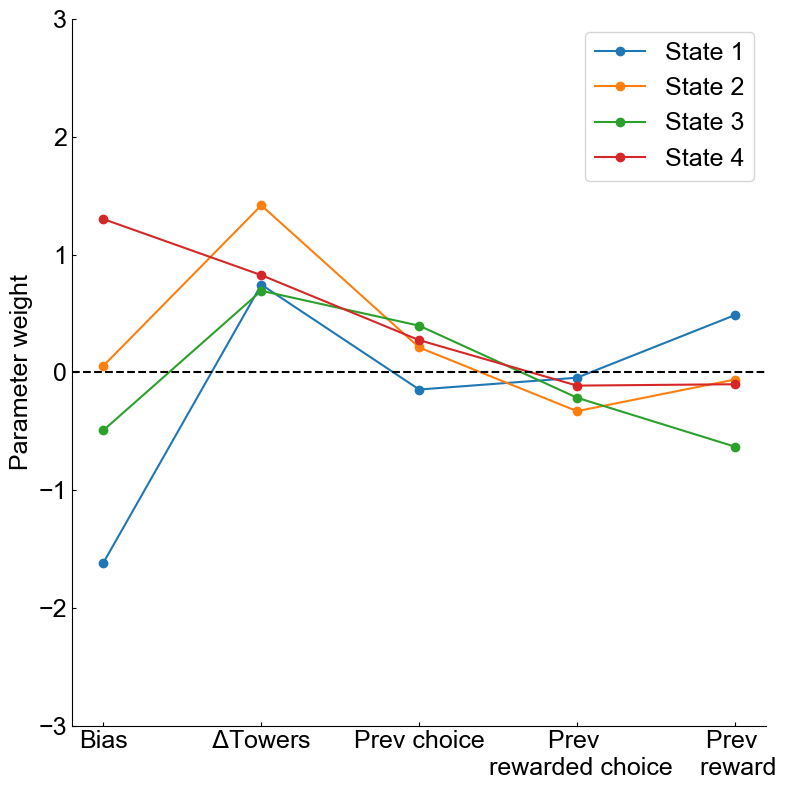

In [560]:
params = -np.squeeze(glmhmm.observations.params).T
colors = sns.color_palette()
fig_params, ax_params = plt.subplots(figsize=(8, 8))
for iState in np.arange(num_states):
    ax_params.plot(params[:, iState], '-o', color=colors[iState])
ax_params.axhline(0, color='k', linestyle='--')
ax_params.set_xticks(np.arange(len(params)))
ax_params.set_ylim(-3, 3)
ax_params.set_xticklabels(['Bias', '$\Delta$Towers', 'Prev choice', 'Prev \n rewarded choice', 'Prev \n reward'])
ax_params.set_ylabel('Parameter weight', fontsize=18)
ax_params.legend(['State 1', 'State 2', 'State 3', 'State 4'], fontsize=18)
ax_params.tick_params(axis='both', which='major', labelsize=18)

#### State statistics

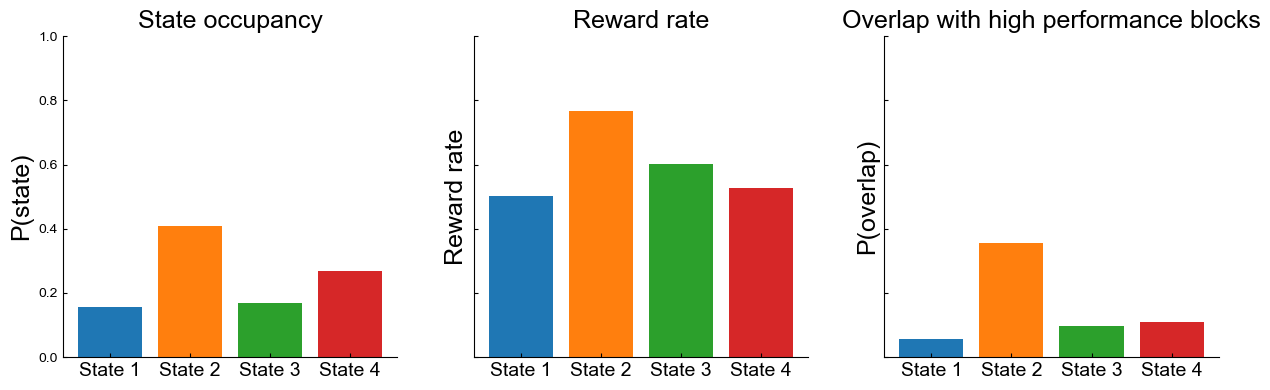

In [561]:
plot_state_stats(glmhmm, data_mouse, inputs_zscored, output)